# Data Preprocessing for Stardist Finetuning

In [1]:
# Imports
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import sys

from sklearn.model_selection import train_test_split

from stardist.models import StarDist2D, Config2D
from stardist import fill_label_holes, calculate_extents, random_label_cmap
from stardist.matching import matching_dataset
from csbdeep.utils import normalize

np.random.seed(42)
lbl_cmap = random_label_cmap()

In [2]:
# Check if GPU is available
gpu = len(tf.config.list_physical_devices('GPU')) > 0
print("GPU: " + str(gpu))
print("TensorFlow: " + str(tf.__version__))

GPU: False
TensorFlow: 2.12.0


In [3]:
# Import WSI images
img_array = np.load('data_old/images.npy')
# Amount of images (# of Images, Width, Height, Channels)
img_array.shape

(4981, 256, 256, 3)

In [4]:
# Import WSI masks
mask_array = np.load('data_old/labels.npy')
# Amount of masks (# of Masks, Width, Height, Channels)
mask_array.shape

(4981, 256, 256, 2)

In [5]:
# Get segmentation maps
segmentation_maps = mask_array[:, :, :, 0]
segmentation_maps.shape

(4981, 256, 256)

In [6]:
# Plot iamges and masks
def plot_img_label(img, lbl, img_title="image", lbl_title="label", **kwargs):
    fig, (ai,al) = plt.subplots(1,2, figsize=(12,5), gridspec_kw=dict(width_ratios=(1.25,1)))
    im = ai.imshow(img, cmap='gray', clim=(0,1))
    ai.set_title(img_title)    
    fig.colorbar(im, ax=ai)
    al.imshow(lbl, cmap=lbl_cmap)
    al.set_title(lbl_title)
    plt.tight_layout()

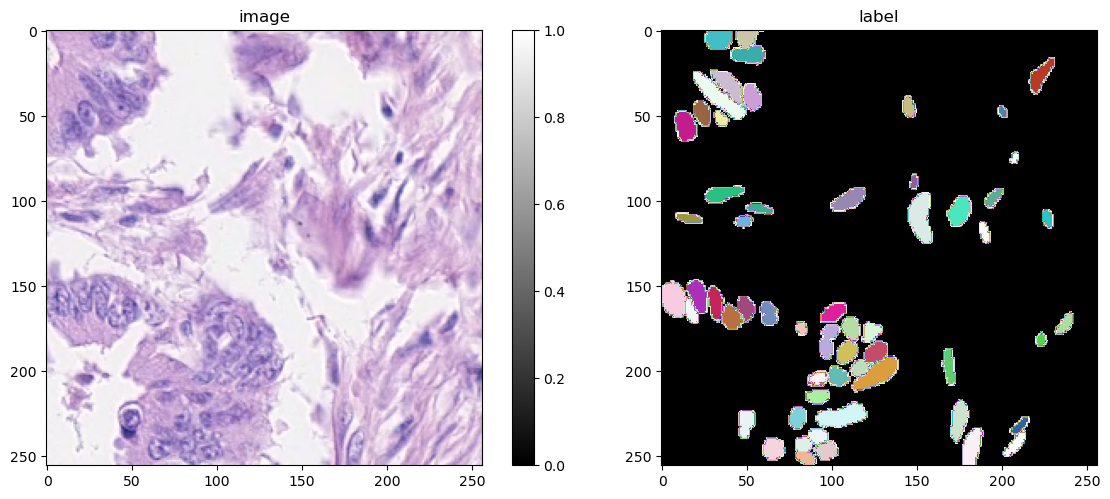

In [7]:
# Sanity check
plot_img_label(img_array[100], segmentation_maps[100])

Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


2024-04-13 09:18:35.140672: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Text(0.5, 1.0, 'Prediction')

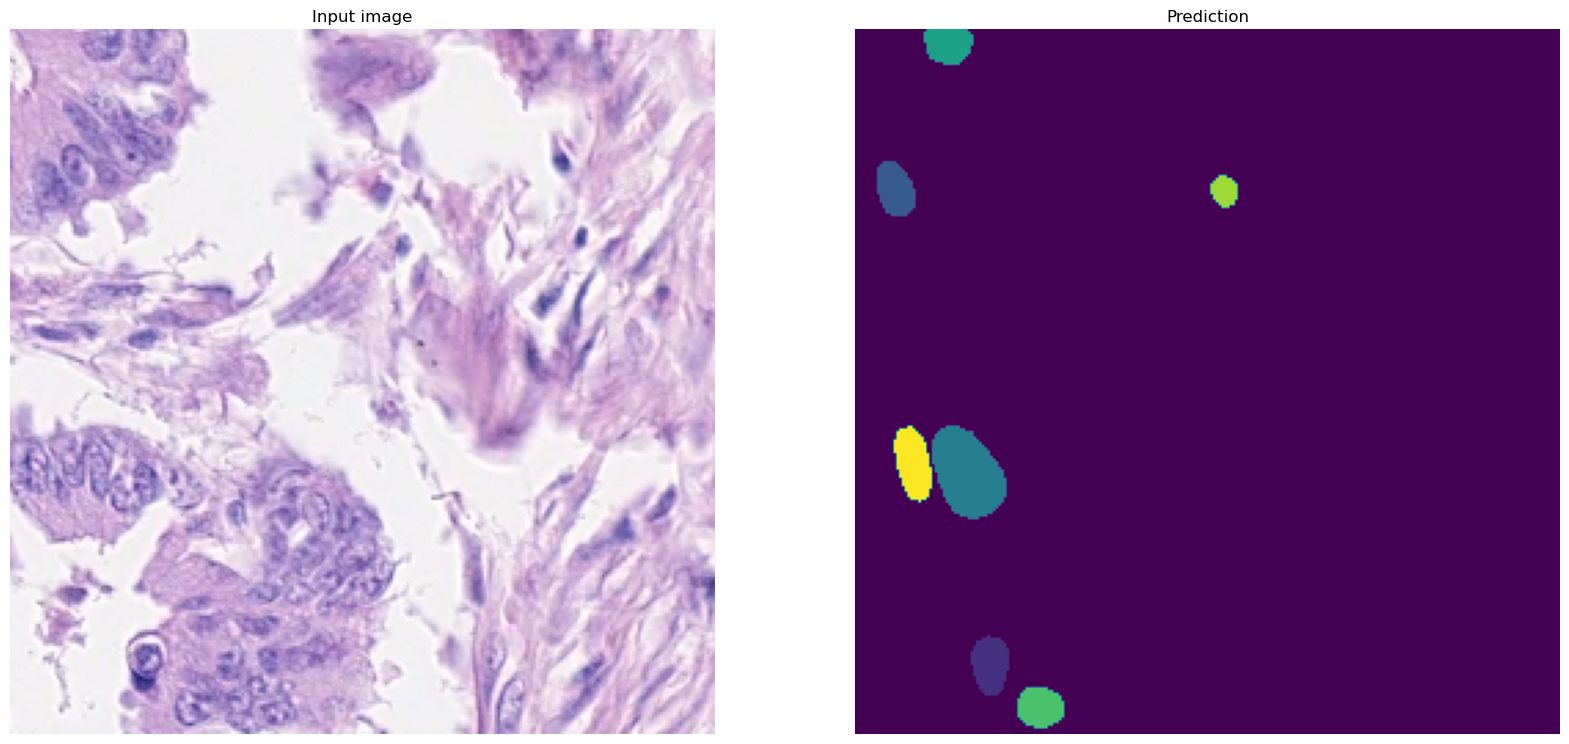

In [8]:
# Test with pretrained:
HE_model = StarDist2D.from_pretrained('2D_versatile_he')
he_labels, features = HE_model.predict_instances(normalize(img_array[100]))
plt.rcParams["figure.figsize"] = (20,10)
plt.subplot(1,2,1)
plt.imshow(img_array[100], cmap="gray")
plt.axis("off")
plt.title("Input image")

plt.subplot(1,2,2)
plt.imshow(he_labels)
plt.axis("off")
plt.title("Prediction")

In [9]:
features

{'coord': array([[[ 2.30000000e+02,  2.31432007e+02,  2.32894440e+02,
           2.34301071e+02,  2.36106384e+02,  2.38263000e+02,
           2.40536362e+02,  2.41521606e+02,  2.41874893e+02,
           2.40468842e+02,  2.38799896e+02,  2.36670151e+02,
           2.34962769e+02,  2.33586914e+02,  2.32344070e+02,
           2.31131104e+02,  2.30000000e+02,  2.28795624e+02,
           2.27450424e+02,  2.25905472e+02,  2.24408615e+02,
           2.22707062e+02,  2.21321625e+02,  2.20696289e+02,
           2.19940994e+02,  2.20331482e+02,  2.20627457e+02,
           2.22091492e+02,  2.23542358e+02,  2.25194534e+02,
           2.26823486e+02,  2.28496185e+02],
         [ 5.55114517e+01,  5.51991959e+01,  5.49877853e+01,
           5.44370155e+01,  5.41063843e+01,  5.35211639e+01,
           5.23643036e+01,  5.02917900e+01,  4.80000000e+01,
           4.59176178e+01,  4.43549652e+01,  4.35431442e+01,
           4.30372314e+01,  4.26317940e+01,  4.23409271e+01,
           4.23135948e+01,  4.1

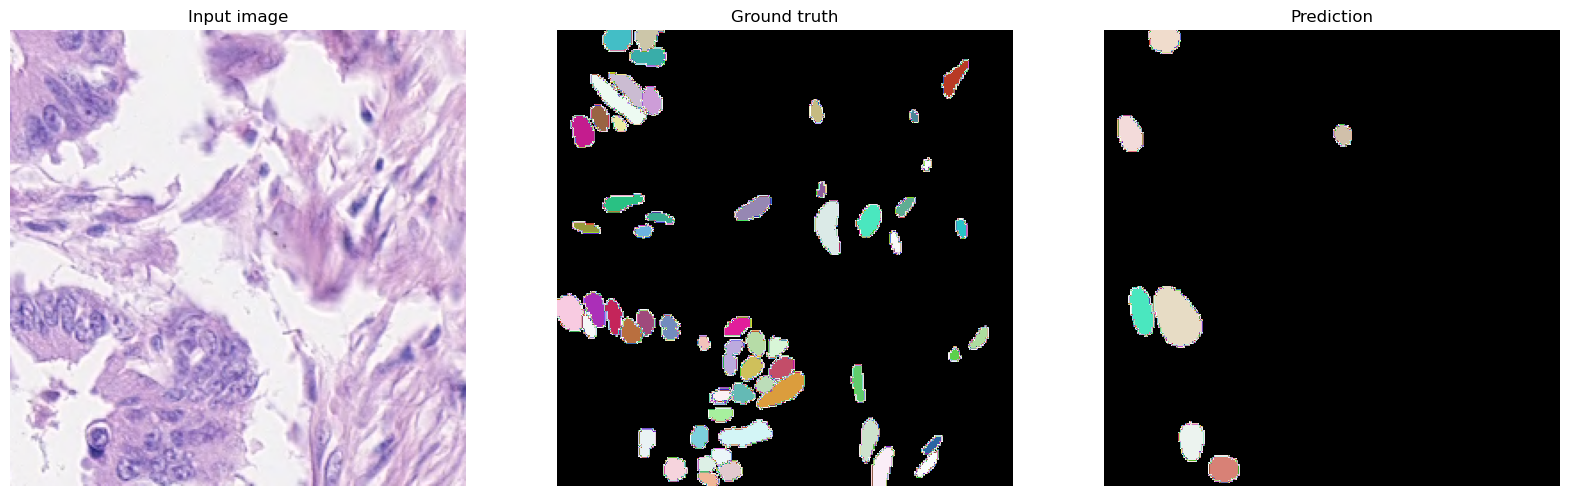

In [13]:
# Plot image next to label next to prediction
plt.rcParams["figure.figsize"] = (20,10)
plt.subplot(1,3,1)
plt.imshow(img_array[100], cmap="gray")
plt.axis("off")
plt.title("Input image")

plt.subplot(1,3,2)
plt.imshow(segmentation_maps[100], cmap=lbl_cmap)
plt.axis("off")
plt.title("Ground truth")

plt.subplot(1,3,3)
plt.imshow(he_labels, cmap=lbl_cmap)
plt.axis("off")
plt.title("Prediction")
plt.savefig('mics/HE_model_prediction.png')

In [101]:
#Normalize input images and fill holes in masks
# If no third dim. then number of channels = 1.
n_channel = 1 if img_array.ndim == 2 else img_array[0].shape[-1]  
# axis_norm = (0,1) # normalize channels independently
axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))
    sys.stdout.flush()

images_norm = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(img_array)]
labels_filled = [fill_label_holes(y) for y in tqdm(segmentation_maps)]

Normalizing image channels jointly.


100%|██████████| 4981/4981 [00:15<00:00, 322.45it/s]


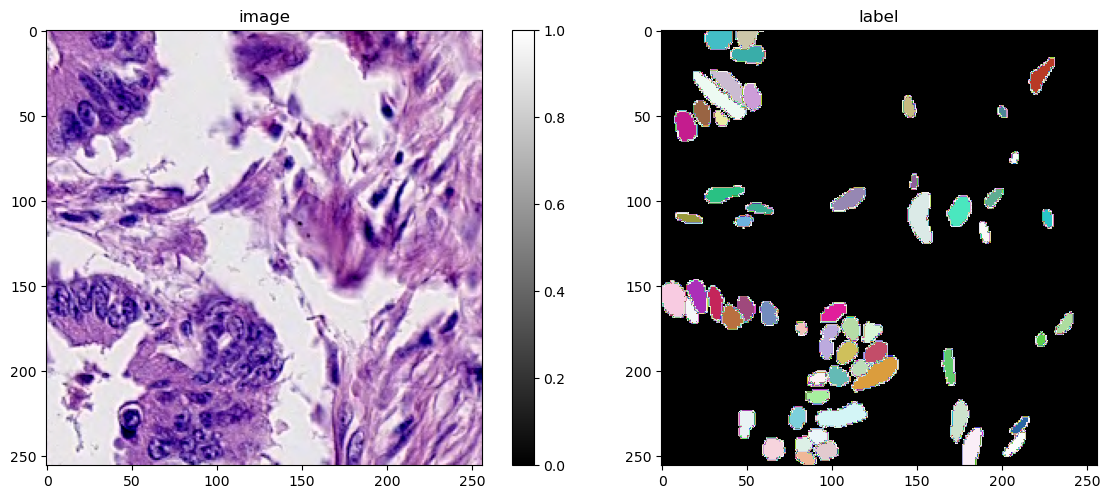

In [102]:
# Example usage (assuming images_norm and labels are already defined and labels have multiple channels)
plot_img_label(images_norm[100], labels_filled[100])

In [103]:
# Split into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(images_norm, labels_filled, test_size=0.2, random_state=42)
print('number of images: %3d' % len(images_norm))
print('- training:       %3d' % len(X_train))
print('- validation:     %3d' % len(X_val))

number of images: 4981
- training:       3984
- validation:     997


In [104]:
#Define a few augmentation methods
def random_fliprot(img, mask): 
    assert img.ndim >= mask.ndim
    axes = tuple(range(mask.ndim))
    perm = tuple(np.random.permutation(axes))
    img = img.transpose(perm + tuple(range(mask.ndim, img.ndim))) 
    mask = mask.transpose(perm) 
    for ax in axes: 
        if np.random.rand() > 0.5:
            img = np.flip(img, axis=ax)
            mask = np.flip(mask, axis=ax)
    return img, mask 

def random_intensity_change(img):
    img = img*np.random.uniform(0.6,2) + np.random.uniform(-0.2,0.2)
    return img


def augmenter(x, y):
    """Augmentation of a single input/label image pair.
    x is an input image
    y is the corresponding ground-truth label image
    """
    x, y = random_fliprot(x, y)
    x = random_intensity_change(x)
    # add some gaussian noise
    sig = 0.02*np.random.uniform(0,1)
    x = x + sig*np.random.normal(0,1,x.shape)
    return x, y

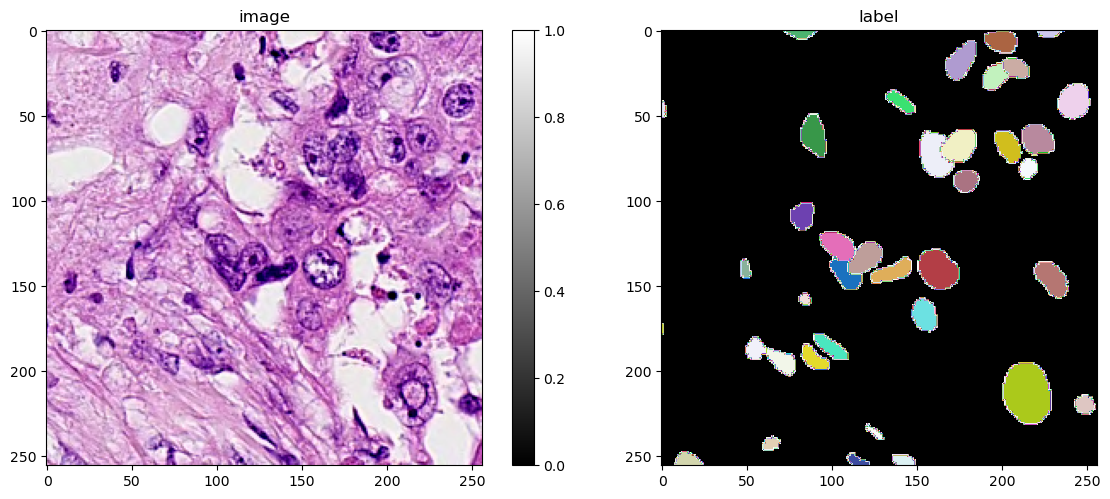

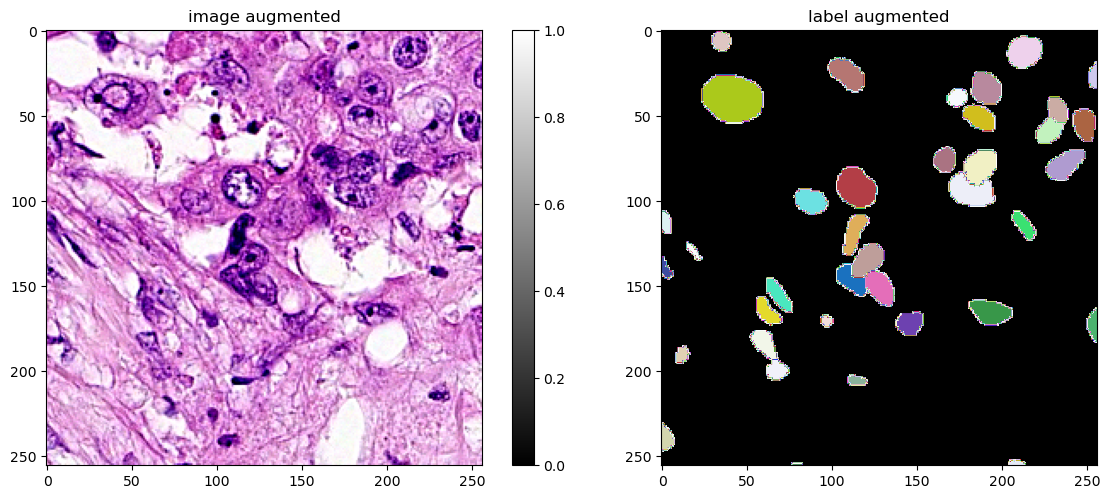

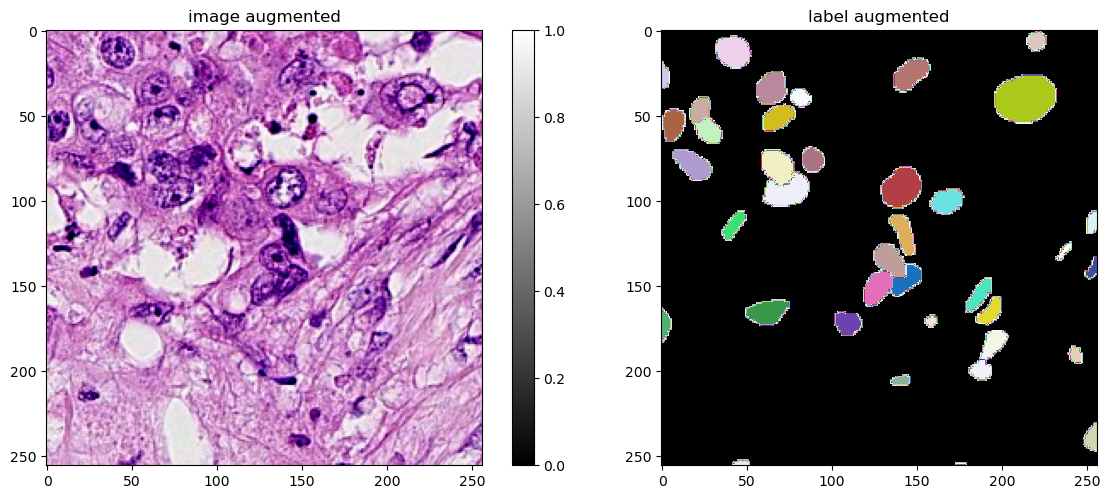

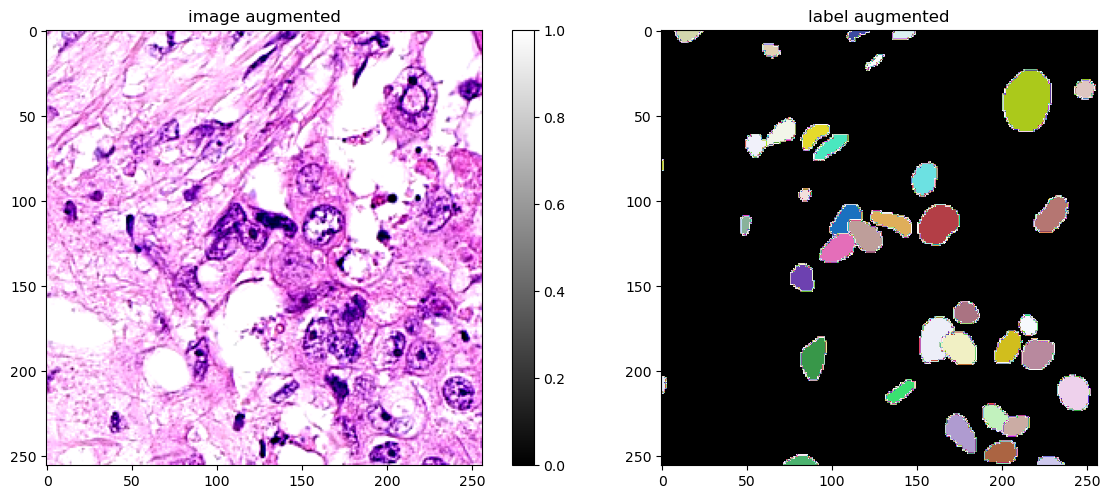

In [105]:
# plot some augmented examples
img, lbl = X_train[9],Y_train[9]
plot_img_label(img, lbl)
for _ in range(3):
    img_aug, lbl_aug = augmenter(img,lbl)
    plot_img_label(img_aug, lbl_aug, img_title="image augmented", lbl_title="label augmented")

# Finetuning

In [106]:
# Check config to get an idea about all parameters
print(Config2D.__doc__)

Configuration for a :class:`StarDist2D` model.

    Parameters
    ----------
    axes : str or None
        Axes of the input images.
    n_rays : int
        Number of radial directions for the star-convex polygon.
        Recommended to use a power of 2 (default: 32).
    n_channel_in : int
        Number of channels of given input image (default: 1).
    grid : (int,int)
        Subsampling factors (must be powers of 2) for each of the axes.
        Model will predict on a subsampled grid for increased efficiency and larger field of view.
    n_classes : None or int
        Number of object classes to use for multi-class predection (use None to disable)
    backbone : str
        Name of the neural network architecture to be used as backbone.
    kwargs : dict
        Overwrite (or add) configuration attributes (see below).


    Attributes
    ----------
    unet_n_depth : int
        Number of U-Net resolution levels (down/up-sampling layers).
    unet_kernel_size : (int,int)
   

In [110]:
#Define the config by setting some parameter values

# 32 is a good default choice (see 1_data.ipynb)
n_rays = 32  #Number of radial directions for the star-convex polygon.

# Use OpenCL-based computations for data generator during training (requires 'gputools')
use_gpu = False and gputools_available()

# Predict on subsampled grid for increased efficiency and larger field of view
grid = (2,2)

conf = Config2D (
    n_rays       = n_rays,
    grid         = grid,
    use_gpu      = use_gpu,
    n_channel_in = n_channel,
)
print(conf)
vars(conf)

Config2D(axes='YXC', backbone='unet', grid=(2, 2), n_channel_in=3, n_channel_out=33, n_classes=None, n_dim=2, n_rays=32, net_conv_after_unet=128, net_input_shape=(None, None, 3), net_mask_shape=(None, None, 1), train_background_reg=0.0001, train_batch_size=4, train_checkpoint='weights_best.h5', train_checkpoint_epoch='weights_now.h5', train_checkpoint_last='weights_last.h5', train_class_weights=(1, 1), train_completion_crop=32, train_dist_loss='mae', train_epochs=400, train_foreground_only=0.9, train_learning_rate=0.0003, train_loss_weights=(1, 0.2), train_n_val_patches=None, train_patch_size=(256, 256), train_reduce_lr={'factor': 0.5, 'patience': 40, 'min_delta': 0}, train_sample_cache=True, train_shape_completion=False, train_steps_per_epoch=100, train_tensorboard=True, unet_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_kernel_size=(3, 3), unet_last_activation='relu', unet_n_conv_per_depth=2, unet_n_depth=3, unet_n_filter_base=32, unet_pool=(2, 2), unet_prefix='', 

{'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 3,
 'n_channel_out': 33,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'n_rays': 32,
 'grid': (2, 2),
 'backbone': 'unet',
 'n_classes': None,
 'unet_n_depth': 3,
 'unet_kernel_size': (3, 3),
 'unet_n_filter_base': 32,
 'unet_n_conv_per_depth': 2,
 'unet_pool': (2, 2),
 'unet_activation': 'relu',
 'unet_last_activation': 'relu',
 'unet_batch_norm': False,
 'unet_dropout': 0.0,
 'unet_prefix': '',
 'net_conv_after_unet': 128,
 'net_input_shape': (None, None, 3),
 'net_mask_shape': (None, None, 1),
 'train_shape_completion': False,
 'train_completion_crop': 32,
 'train_patch_size': (256, 256),
 'train_background_reg': 0.0001,
 'train_foreground_only': 0.9,
 'train_sample_cache': True,
 'train_dist_loss': 'mae',
 'train_loss_weights': (1, 0.2),
 'train_class_weights': (1, 1),
 'train_epochs': 400,
 'train_steps_per_epoch': 100,
 'train_learning_rate': 0.0003,


In [111]:
# Save model to the specified directory
model = StarDist2D(conf, name='NucleiSegmentor', basedir='models/')

Using default values: prob_thresh=0.5, nms_thresh=0.4.


In [112]:
# Define the network field of view to size larger than the median object size
median_size = calculate_extents(list(labels_filled), np.median)
fov = np.array(model._axes_tile_overlap('YX'))
print(f"median object size:      {median_size}")
print(f"network field of view :  {fov}")
if any(median_size > fov):
    print("WARNING: median object size larger than field of view of the neural network.")

median object size:      [10.  10.5]
network field of view :  [94 94]


In [113]:
# Train the model
model.train(X_train, Y_train, validation_data=(X_val,Y_val), augmenter=augmenter, epochs=20, steps_per_epoch=100)

Epoch 1/20


2024-03-19 13:00:25.068599: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


100/100 [==============================] - 70s 691ms/step - loss: 1.1284 - prob_loss: 0.3518 - dist_loss: 3.8832 - prob_kld: 0.2575 - dist_relevant_mae: 3.8829 - dist_relevant_mse: 26.7361 - dist_dist_iou_metric: 0.1553 - val_loss: 0.8696 - val_prob_loss: 0.3017 - val_dist_loss: 2.8395 - val_prob_kld: 0.2107 - val_dist_relevant_mae: 2.8392 - val_dist_relevant_mse: 15.5553 - val_dist_dist_iou_metric: 0.3040 - lr: 3.0000e-04
Epoch 2/20
100/100 [==============================] - 72s 720ms/step - loss: 0.8641 - prob_loss: 0.2730 - dist_loss: 2.9554 - prob_kld: 0.1851 - dist_relevant_mae: 2.9550 - dist_relevant_mse: 16.3094 - dist_dist_iou_metric: 0.3097 - val_loss: 0.7985 - val_prob_loss: 0.2356 - val_dist_loss: 2.8143 - val_prob_kld: 0.1446 - val_dist_relevant_mae: 2.8138 - val_dist_relevant_mse: 13.7863 - val_dist_dist_iou_metric: 0.3660 - lr: 3.0000e-04
Epoch 3/20
100/100 [==============================] - 72s 721ms/step - loss: 0.7861 - prob_loss: 0.2379 - dist_loss: 2.7412 - prob_kld:

In [114]:
#Optimize the thresolds using the trained model
model.optimize_thresholds(X_val, Y_val)

NMS threshold = 0.5:  80%|████████  | 16/20 [02:10<00:32,  8.18s/it, 0.491 -> 0.440]


Using optimized values: prob_thresh=0.467853, nms_thresh=0.3.
Saving to 'thresholds.json'.


{'prob': 0.46785282326358624, 'nms': 0.3}

In [115]:
#Load saved model
my_model = StarDist2D(None, name='NucleiSegmentor', basedir='models/')
model=my_model

Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.467853, nms_thresh=0.3.


In [116]:
#Predict on validation images
Y_val_pred = [model.predict_instances(x, n_tiles=model._guess_n_tiles(x), show_tile_progress=False)[0]
              for x in tqdm(X_val)]

100%|██████████| 997/997 [01:03<00:00, 15.66it/s]


100%|██████████| 9/9 [00:13<00:00,  1.51s/it]


DatasetMatching(criterion='iou', thresh=0.5, fp=35049, tp=74198, fn=40889, precision=0.6791765448936813, recall=0.6447122611589493, accuracy=0.4942052539031278, f1=0.6614958053616482, n_true=115087, n_pred=109247, mean_true_score=0.45634722129959715, mean_matched_score=0.7078308398839152, panoptic_quality=0.46822713148882233, by_image=False)

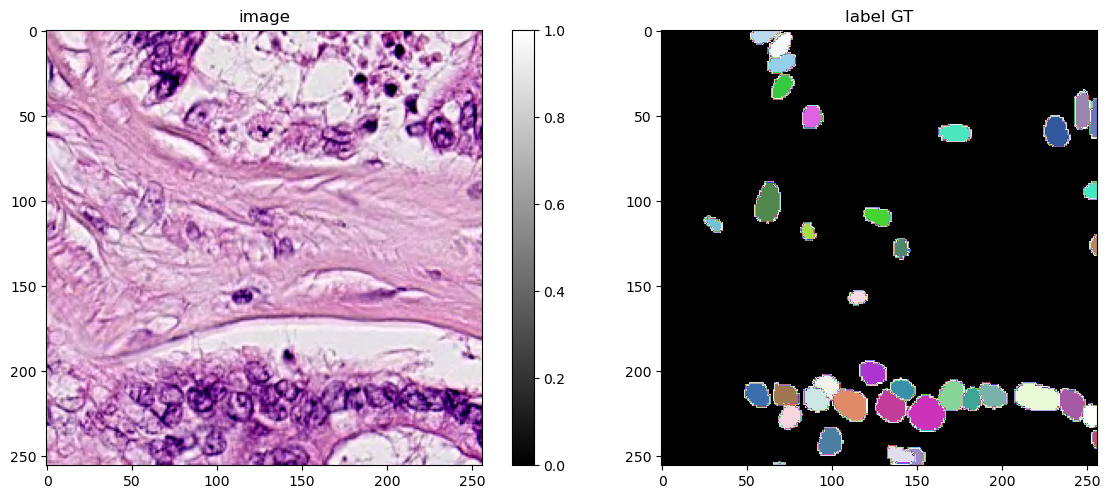

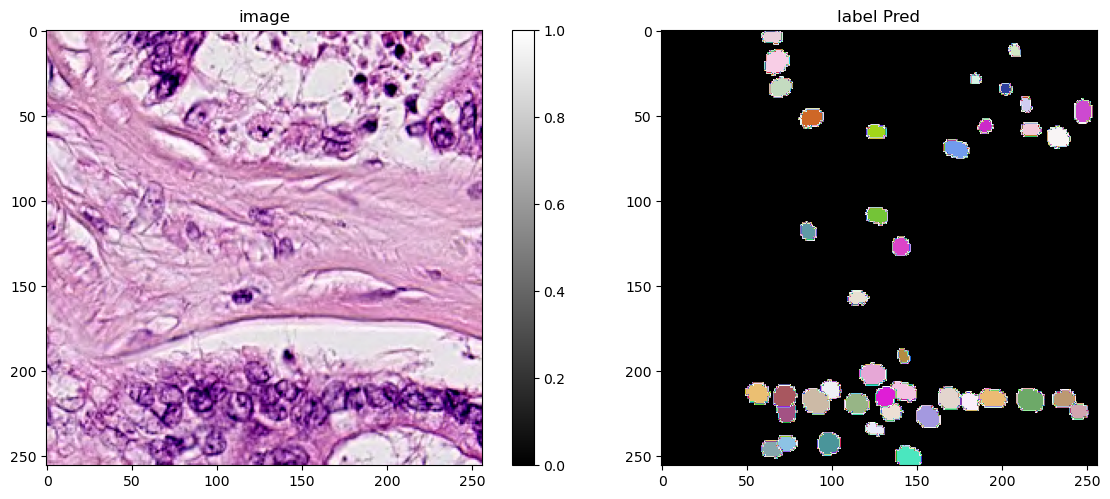

In [117]:
#PLot original labels and predcitions
plot_img_label(X_val[0],Y_val[0], lbl_title="label GT")
plot_img_label(X_val[0],Y_val_pred[0], lbl_title="label Pred")


taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
stats = [matching_dataset(Y_val, Y_val_pred, thresh=t, show_progress=False) for t in tqdm(taus)]

stats[taus.index(0.5)]

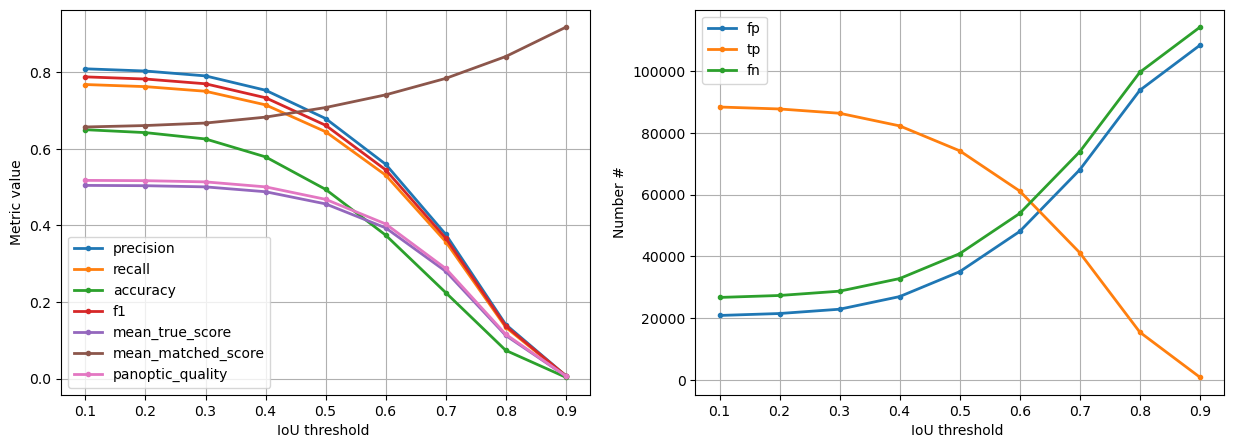

In [118]:
#Plot key metrics 
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

for m in ('precision', 'recall', 'accuracy', 'f1', 'mean_true_score', 'mean_matched_score', 'panoptic_quality'):
    ax1.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax1.set_xlabel(r'IoU threshold ')
ax1.set_ylabel('Metric value')
ax1.grid()
ax1.legend()

for m in ('fp', 'tp', 'fn'):
    ax2.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax2.set_xlabel(r'IoU threshold ')
ax2.set_ylabel('Number #')
ax2.grid()
ax2.legend();